In [1]:
import numpy as np
from sklearn.utils import shuffle
from time import time
from scipy import special
import matplotlib.pyplot as plt

In [2]:
np.random.seed(seed=0)

## Loading Data

In [3]:
# Train data
data_train = np.loadtxt('./Alphabets/train.csv', delimiter=',')
x_train = data_train[:, 0: -1]
y_train = data_train[:, -1]

In [4]:
# Test data
data_test = np.loadtxt('./Alphabets/test.csv', delimiter=',')
x_test = data_test[:, 0: -1]
y_test = data_test[:, -1]

### Part A

In [5]:
class NeuralNetwork:
    
    def __init__(self, batch_size, 
                 num_features, 
                 hidden_layers, 
                 target_classes, 
                 learning_rate, 
                 activation = 'sigmoid', 
                 random = False, 
                 max_epochs = 1000,
                 learning_rate_type='constant',
                 n_iter_no_change = 10,
                 EPSILON = 1e-4,
                 verbose = True):
        
        # Initialisation
        self.batch_size = batch_size
        self.num_features = num_features
        self.target_classes = target_classes
        self._activation = activation
        self._learning_rate = learning_rate
        self._base_learning_rate = learning_rate
        self._learning_rate_type = learning_rate_type
        self.max_epochs = max_epochs
        self.n_iter_no_change = n_iter_no_change
        self.EPSILON = EPSILON
        self.verbose = verbose
        
        # Layers is dictionary containing different values
        self.layers = {}
        self.layers['output'] = []
        self.layers['params'] = []
        self.layers['delta'] = []
        # Output before activation is applied        
        self.layers['preactivation'] = []
        
        if random:
            # If random initialisation is true
            self._rand_init(hidden_layers)
        else: 
            self._zero_init(hidden_layers)
        
    def __range(self, x):
        return np.sqrt(2 / x);
    
    # Initialise layers randomly
    def _rand_init(self, hidden_layers):
                
        # Initialising biases and params as randaom
        curr_layer = np.random.randn(hidden_layers[0], self.num_features + 1) * self.__range(self.num_features + 1)
        self.layers['params'] = [curr_layer]
        
        for i in range(1, len(hidden_layers)):
            
            # Values for a layer
            num_perceptrons = hidden_layers[i]
            num_params = hidden_layers[i - 1]
            
            curr_layer = np.random.randn(num_perceptrons, num_params + 1) * self.__range(num_params + 1)            
            self.layers['params'].append(curr_layer)
            
        # Output layer
        curr_layer = np.random.randn(self.target_classes, hidden_layers[len(hidden_layers) - 1] + 1) * self.__range(hidden_layers[len(hidden_layers) - 1] + 1)
        self.layers['params'].append(curr_layer) 
        
    
    # Initialise layers with 0
    def _zero_init(self, hidden_layers):
        
        
        self.layers['params'] = [np.zeros((hidden_layers[0], self.num_features + 1))]
        for i in range(1, len(hidden_layers)):
            
            # Values for a layer
            num_perceptrons = hidden_layers[i]
            num_params = hidden_layers[i - 1] + 1
            
            self.layers['params'].append(np.zeros((num_perceptrons, num_params)))
        
        # Output layer
        self.layers['params'].append(np.zeros((self.target_classes, hidden_layers[len(hidden_layers) - 1] + 1))) 
    
    # Activation function
    def _activate(self, x, is_hidden):
        
        # If it is the hidden layer
        if is_hidden:
            if self._activation == 'sigmoid':
                return self._sigmoid(x)
            else:
                return self._relu(x)
        else:
            # Output layer has sigmoid activation
            return self._sigmoid(x)
        
    # Derivative of the acivation function
    def _der_activation(self, x, is_hidden):
        # If it is the hidden layer
        if is_hidden:
            if self._activation == 'sigmoid':
                return self._der_sigmoid(x)
            else:
                return self._der_relu(x)
        else:
            # Output layer has sigmoid activation
            return self._der_sigmoid(x)
    
    # Relu
    def _relu(self, x):
        return np.maximum(0, x)
    
    # Derivative of Relu
    def _der_relu(self, x):
        return (np.ones_like(x) * (x >= 0))
        
    # Sigmoid
    def _sigmoid(self, x):
        return special.expit(x)
    
    # Derivative of sigmoid
    def _der_sigmoid(self, x):
        s = self._sigmoid(x)
        return (s * (1 - s))
    
    # Returning the predictions
    def predict(self, x, debug = False):
        
        pred = self.forward(x, debug)
        pred = np.argmax(pred, axis=0)    
        return pred
    
    # Passing data in the forward direction
    def forward(self, x, debug = False):
        
        layer_input = np.array(x)
        self.layers['preactivation'] = []
        self.layers['output'] = []
        
        #If layer is hidden layer
        is_hidden = True
        
        for (i, layer) in enumerate(self.layers['params']):
            
            if i == len(self.layers['params']) - 1:
                is_hidden = False

            # Appending one for bias term
            layer_input = np.append(layer_input, np.ones((1, layer_input.shape[1])), axis = 0)

            # Output before activation
            z = layer @ layer_input
            self.layers['preactivation'].append(z)

            if debug:
                print(z)

            layer_input = self._activate(z, is_hidden)

            # Output of this layer is input of next
            self.layers['output'].append(layer_input)
        
        return layer_input
        
        
    # Back propogating derivatives
    def back_propogate(self, y):
        
        # y is such that ith column contains the ith sample
        num_layers = len(self.layers['params'])
        
        # Initialising delta list
        self.layers['delta'] = []
        
        # To check if we are on a hidden layer
        is_hidden = False
        
        # Running the loop in reverse 
        for i in range(num_layers):
            
            # Output of current layer
            layer_output = self.layers['output'][num_layers - i - 1]
            layer_output_preactivation = self.layers['preactivation'][num_layers - i - 1]
            
            if not is_hidden:
                
                # Output Layer
                temp = (y - layer_output) * self._der_activation(layer_output_preactivation, is_hidden=is_hidden)
                
                self.layers['delta'].append(temp)
                                       
                # switching is hidden
                is_hidden = True
                
            else:
                
                # delta of next layer
                del_next = self.layers['delta'][i - 1]
                
                # Theta or params of next layer without bias
                theta_next = self.layers['params'][num_layers - i][:, 0 : -1]
                del_theta = theta_next.T @ del_next
                temp = del_theta * self._der_activation(layer_output_preactivation, is_hidden=is_hidden)
                
                self.layers['delta'].append(temp)
                
        self.layers['delta'].reverse()
    
    def _cost(self, x, y):
        
        pred = self.forward(x)
        cost = ((y - pred) ** 2)
        
        cost = np.sum(cost)
        cost /= (2 * y.shape[-1])
        
        return cost
        
    
    
    # Train the model
    def train(self, x, y):
        
        total_samples = y.shape[-1]
        
        diff = np.inf
        old_cost = 0
        new_cost = 0
        num_change = 0
        
        count = 0
        
        while True:
            if count == self.max_epochs:
                pred = self.predict(x)
                y_temp = np.argmax(y, axis=0) 
                acc = np.sum(self.predict(x) == y_temp) / y_temp.shape[0]
                print("Max iterations reached | Training accuracy => {}".format(acc))
                return
            
            # Old cost
            old_cost = new_cost
            
            if self.verbose:
                print("#Epoch => {} | Cost: {} | Difference in cost => {}".format(count, old_cost, diff))
            
            count += 1
            
            for i in range(0, total_samples, self.batch_size):
                
                x_curr = np.array(x[:, i : i + self.batch_size])
                y_curr = np.array(y[:, i : i + self.batch_size])
                
                gradient = []
                
                # Initialising the gradient shape
                for layer in self.layers['params']:
                    gradient.append(np.zeros_like(layer))
                  
                  
                # Assigning values to outputs and deltas
                self.forward(x_curr)
                self.back_propogate(y_curr)
                
                # Computing gradient layer wise
                for i in range(len(self.layers['params'])):

                    # Updating for each layer
                    if i == 0:
                        # If its the first layer
                        x_i_k = np.array(x_curr)
                    else:    
                        x_i_k = np.array(self.layers['output'][i - 1])

                    # 1 for bias
                    x_i_k = np.append(x_i_k, np.ones((1, x_i_k.shape[1])), axis = 0)
                    delta = np.array(self.layers['delta'][i])

                    gradient[i] = ((-delta) @ x_i_k.T) / self.batch_size
                
                # If learning rate is adaptive
                if self._learning_rate_type == 'adaptive':
                    self._learning_rate = self._base_learning_rate / np.sqrt(count)
                
                # Updating parameters layer wise
                for (i, layer) in enumerate(self.layers['params']):  
                    self.layers['params'][i] = self.layers['params'][i] - self._learning_rate * gradient[i]
                
    
            # New cost
            new_cost = self._cost(x, y)
            diff = old_cost - new_cost
            
            # Difference in cost
            if diff < self.EPSILON:
                num_change += 1
            else:
                num_change = 0
            
            # If change less than EPSILON for n_iter_no_change consecutive iterations
            if num_change == self.n_iter_no_change:
                
                pred = self.predict(x)
                y_temp = np.argmax(y, axis=0)
                pred = self.predict(x)
                y_temp = np.argmax(y, axis=0) 
                acc = np.sum(self.predict(x) == y_temp) / y_temp.shape[0]

                print("Training complete | Epochs => {} | Training accuracy => {}".format(count, acc))

                return
                    
        

In [6]:
def get_one_hot_encoding(y, max_range):
    
    ans = np.zeros((max_range, y.shape[0]))
    for (i, val) in enumerate(y):
        ans[int(val), i] = 1
        
    return ans                     

### Part B

In [7]:
# Modifying training data to send to model and shuffling
x_train_, y_train_ = shuffle(x_train, y_train)
x_train_new = np.array(x_train_.T) / 255
y_train_new = get_one_hot_encoding(y_train_, 26)
x_test_new = np.array(x_test.T) / 255

In [8]:
hidden_layer = [1, 5, 10, 50, 100]

In [9]:
# To get the accuracies and training time for the hidden layer sizes
def get_accuracies(hidden_layer, EPSILON = 1e-4, learning_rate_type = 'constant', learning_rate = 0.1):
    
    # Initialising lists
    training_time = []
    acc_train = []
    acc_test = []
    
    for h in hidden_layer:
        print("Training model: ", h)
        model = NeuralNetwork(batch_size=100, 
                              num_features=x_train.shape[-1], 
                              hidden_layers = [h], 
                              target_classes= 26, 
                              learning_rate=learning_rate, 
                              learning_rate_type=learning_rate_type,
                              random=True,
                              EPSILON=EPSILON,
                              verbose=True)
        t0 = time()
        model.train(x_train_new, y_train_new)

        # Training time
        training_time.append(time() - t0)

        # Predicting
        pred_train = model.predict(x_train_new)
        pred_test = model.predict(x_test_new)

        # Accuracy over different data sets
        train_acc = np.sum(pred_train == y_train_) / y_train_.shape[0]
        test_acc = np.sum(pred_test == y_test) / y_test.shape[0]

        acc_train.append(train_acc)
        acc_test.append(test_acc)
    return acc_train, acc_test, training_time

In [10]:
acc_train, acc_test, training_time = get_accuracies(hidden_layer=hidden_layer)

Training model:  1
#Epoch => 0 | Cost: 0 | Difference in cost => inf
#Epoch => 1 | Cost: 1.3043349613543587 | Difference in cost => -1.3043349613543587
#Epoch => 2 | Cost: 0.8071867589673829 | Difference in cost => 0.49714820238697577
#Epoch => 3 | Cost: 0.6646037232958938 | Difference in cost => 0.1425830356714891
#Epoch => 4 | Cost: 0.6020973263803225 | Difference in cost => 0.06250639691557125
#Epoch => 5 | Cost: 0.5681183974709001 | Difference in cost => 0.033978928909422446
#Epoch => 6 | Cost: 0.5472022581305704 | Difference in cost => 0.020916139340329654
#Epoch => 7 | Cost: 0.5332420750163487 | Difference in cost => 0.013960183114221758
#Epoch => 8 | Cost: 0.5233787406267344 | Difference in cost => 0.009863334389614287
#Epoch => 9 | Cost: 0.5161090894613317 | Difference in cost => 0.00726965116540268
#Epoch => 10 | Cost: 0.5105732893144608 | Difference in cost => 0.0055358001468709395
#Epoch => 11 | Cost: 0.5062468627681576 | Difference in cost => 0.004326426546303219
#Epoch => 

#Epoch => 44 | Cost: 0.46976987627845873 | Difference in cost => 0.0003399397703285345
#Epoch => 45 | Cost: 0.46944547654691227 | Difference in cost => 0.0003243997315464653
#Epoch => 46 | Cost: 0.46913157801721816 | Difference in cost => 0.00031389852969410104
#Epoch => 47 | Cost: 0.4688259235836437 | Difference in cost => 0.00030565443357444266
#Epoch => 48 | Cost: 0.4685273954252025 | Difference in cost => 0.0002985281584412247
#Epoch => 49 | Cost: 0.46823532485503605 | Difference in cost => 0.0002920705701664472
#Epoch => 50 | Cost: 0.46794922731119915 | Difference in cost => 0.0002860975438369051
#Epoch => 51 | Cost: 0.46766870088434015 | Difference in cost => 0.00028052642685899576
#Epoch => 52 | Cost: 0.4673933854196852 | Difference in cost => 0.00027531546465492385
#Epoch => 53 | Cost: 0.46712294434925533 | Difference in cost => 0.0002704410704298943
#Epoch => 54 | Cost: 0.4668570555148483 | Difference in cost => 0.00026588883440703537
#Epoch => 55 | Cost: 0.4665954059197096 | 

#Epoch => 140 | Cost: 0.4407237991443011 | Difference in cost => 0.00032139812575149307
#Epoch => 141 | Cost: 0.4404085289799653 | Difference in cost => 0.00031527016433580135
#Epoch => 142 | Cost: 0.44009912840811144 | Difference in cost => 0.0003094005718538573
#Epoch => 143 | Cost: 0.43979534265304704 | Difference in cost => 0.00030378575506440075
#Epoch => 144 | Cost: 0.43949692156455533 | Difference in cost => 0.0002984210884917071
#Epoch => 145 | Cost: 0.439203620667744 | Difference in cost => 0.00029330089681134375
#Epoch => 146 | Cost: 0.4389152021191552 | Difference in cost => 0.000288418548588798
#Epoch => 147 | Cost: 0.43863143550901695 | Difference in cost => 0.00028376661013823634
#Epoch => 148 | Cost: 0.4383520984874217 | Difference in cost => 0.00027933702159527174
#Epoch => 149 | Cost: 0.4380769772164946 | Difference in cost => 0.00027512127092710337
#Epoch => 150 | Cost: 0.43780586666375 | Difference in cost => 0.00027111055274459117
#Epoch => 151 | Cost: 0.43753857075

#Epoch => 236 | Cost: 0.4204347004700282 | Difference in cost => 0.00016444653886504845
#Epoch => 237 | Cost: 0.42027103051435544 | Difference in cost => 0.00016366995567274056
#Epoch => 238 | Cost: 0.4201081331095893 | Difference in cost => 0.00016289740476616021
#Epoch => 239 | Cost: 0.41994600374130076 | Difference in cost => 0.00016212936828852165
#Epoch => 240 | Cost: 0.4197846373949688 | Difference in cost => 0.00016136634633195923
#Epoch => 241 | Cost: 0.4196240285355164 | Difference in cost => 0.00016060885945240466
#Epoch => 242 | Cost: 0.41946417108382406 | Difference in cost => 0.00015985745169233567
#Epoch => 243 | Cost: 0.4193050583896685 | Difference in cost => 0.00015911269415558316
#Epoch => 244 | Cost: 0.41914668320045895 | Difference in cost => 0.0001583751892095253
#Epoch => 245 | Cost: 0.4189890376250604 | Difference in cost => 0.00015764557539854618
#Epoch => 246 | Cost: 0.41883211309188967 | Difference in cost => 0.00015692453317073252
#Epoch => 247 | Cost: 0.4186

#Epoch => 329 | Cost: 0.4056361655030582 | Difference in cost => 0.00017766535041746634
#Epoch => 330 | Cost: 0.4054572417640853 | Difference in cost => 0.00017892373897288039
#Epoch => 331 | Cost: 0.4052768958506492 | Difference in cost => 0.0001803459134361307
#Epoch => 332 | Cost: 0.4050949487469417 | Difference in cost => 0.00018194710370750267
#Epoch => 333 | Cost: 0.4049112074230828 | Difference in cost => 0.00018374132385889919
#Epoch => 334 | Cost: 0.40472546761623346 | Difference in cost => 0.00018573980684932767
#Epoch => 335 | Cost: 0.40453751863375187 | Difference in cost => 0.00018794898248158942
#Epoch => 336 | Cost: 0.4043471505432716 | Difference in cost => 0.00019036809048028625
#Epoch => 337 | Cost: 0.4041541638884997 | Difference in cost => 0.00019298665477190946
#Epoch => 338 | Cost: 0.4039583816791602 | Difference in cost => 0.00019578220933946788
#Epoch => 339 | Cost: 0.40375966286559156 | Difference in cost => 0.00019871881356864352
#Epoch => 340 | Cost: 0.403557

#Epoch => 425 | Cost: 0.38791248226467645 | Difference in cost => 0.00015176485441220633
#Epoch => 426 | Cost: 0.3877608886452977 | Difference in cost => 0.0001515936193787759
#Epoch => 427 | Cost: 0.38760944950111575 | Difference in cost => 0.00015143914418191962
#Epoch => 428 | Cost: 0.38745814838667336 | Difference in cost => 0.00015130111444239258
#Epoch => 429 | Cost: 0.38730696918170754 | Difference in cost => 0.00015117920496582338
#Epoch => 430 | Cost: 0.387155896103916 | Difference in cost => 0.00015107307779155255
#Epoch => 431 | Cost: 0.3870049137237316 | Difference in cost => 0.00015098238018440568
#Epoch => 432 | Cost: 0.38685400698113687 | Difference in cost => 0.00015090674259471415
#Epoch => 433 | Cost: 0.3867031612045556 | Difference in cost => 0.0001508457765812543
#Epoch => 434 | Cost: 0.38655236213183414 | Difference in cost => 0.00015079907272147475
#Epoch => 435 | Cost: 0.38640159593330853 | Difference in cost => 0.00015076619852560924
#Epoch => 436 | Cost: 0.3862

#Epoch => 518 | Cost: 0.37408477494054776 | Difference in cost => 0.00013458190460813313
#Epoch => 519 | Cost: 0.3739507901496935 | Difference in cost => 0.00013398479085424686
#Epoch => 520 | Cost: 0.37381740409505926 | Difference in cost => 0.00013338605463425468
#Epoch => 521 | Cost: 0.37368461803469316 | Difference in cost => 0.00013278606036609686
#Epoch => 522 | Cost: 0.3735524328743359 | Difference in cost => 0.00013218516035723438
#Epoch => 523 | Cost: 0.3734208491796018 | Difference in cost => 0.00013158369473414977
#Epoch => 524 | Cost: 0.3732898671881879 | Difference in cost => 0.0001309819914138699
#Epoch => 525 | Cost: 0.3731594868220723 | Difference in cost => 0.00013038036611562331
#Epoch => 526 | Cost: 0.3730297076996621 | Difference in cost => 0.00012977912241018963
#Epoch => 527 | Cost: 0.3729005291478646 | Difference in cost => 0.00012917855179750415
#Epoch => 528 | Cost: 0.37277195021404624 | Difference in cost => 0.00012857893381834629
#Epoch => 529 | Cost: 0.37264

#Epoch => 17 | Cost: 0.47461424261485047 | Difference in cost => 0.000398998084652713
#Epoch => 18 | Cost: 0.47422050726094084 | Difference in cost => 0.00039373535390963
#Epoch => 19 | Cost: 0.4738283819890683 | Difference in cost => 0.0003921252718725454
#Epoch => 20 | Cost: 0.4734358518196253 | Difference in cost => 0.0003925301694430172
#Epoch => 21 | Cost: 0.473042400845011 | Difference in cost => 0.00039345097461429557
#Epoch => 22 | Cost: 0.4726485030962124 | Difference in cost => 0.0003938977487985551
#Epoch => 23 | Cost: 0.472254883446819 | Difference in cost => 0.00039361964939343963
#Epoch => 24 | Cost: 0.471861899956595 | Difference in cost => 0.00039298349022398593
#Epoch => 25 | Cost: 0.4714693024975923 | Difference in cost => 0.00039259745900271925
#Epoch => 26 | Cost: 0.47107632727652893 | Difference in cost => 0.0003929752210633519
#Epoch => 27 | Cost: 0.470681918905053 | Difference in cost => 0.00039440837147591834
#Epoch => 28 | Cost: 0.4702849178014438 | Difference 

#Epoch => 113 | Cost: 0.40634710488092746 | Difference in cost => 0.0007043957855594196
#Epoch => 114 | Cost: 0.4056402819088385 | Difference in cost => 0.0007068229720889607
#Epoch => 115 | Cost: 0.4049300956055119 | Difference in cost => 0.0007101863033265876
#Epoch => 116 | Cost: 0.4042156032043226 | Difference in cost => 0.000714492401189315
#Epoch => 117 | Cost: 0.40349587341780735 | Difference in cost => 0.0007197297865152441
#Epoch => 118 | Cost: 0.40277001103589155 | Difference in cost => 0.0007258623819157983
#Epoch => 119 | Cost: 0.4020371878903168 | Difference in cost => 0.000732823145574768
#Epoch => 120 | Cost: 0.4012966790156081 | Difference in cost => 0.0007405088747086674
#Epoch => 121 | Cost: 0.40054790161168413 | Difference in cost => 0.0007487774039239836
#Epoch => 122 | Cost: 0.3997904532582007 | Difference in cost => 0.0007574483534834586
#Epoch => 123 | Cost: 0.39902414507753625 | Difference in cost => 0.0007663081806644212
#Epoch => 124 | Cost: 0.3982490254748627

#Epoch => 209 | Cost: 0.32573556473506105 | Difference in cost => 0.0008817482854940883
#Epoch => 210 | Cost: 0.3248583954584311 | Difference in cost => 0.0008771692766299521
#Epoch => 211 | Cost: 0.3239858094723172 | Difference in cost => 0.000872585986113894
#Epoch => 212 | Cost: 0.3231178127959988 | Difference in cost => 0.0008679966763183722
#Epoch => 213 | Cost: 0.3222544127668347 | Difference in cost => 0.0008634000291641297
#Epoch => 214 | Cost: 0.3213956177800631 | Difference in cost => 0.0008587949867716049
#Epoch => 215 | Cost: 0.3205414371604346 | Difference in cost => 0.0008541806196284973
#Epoch => 216 | Cost: 0.31969188113943736 | Difference in cost => 0.000849556020997233
#Epoch => 217 | Cost: 0.31884696091258713 | Difference in cost => 0.000844920226850232
#Epoch => 218 | Cost: 0.3180066887518192 | Difference in cost => 0.0008402721607679298
#Epoch => 219 | Cost: 0.3171710781487226 | Difference in cost => 0.0008356106030966148
#Epoch => 220 | Cost: 0.31634014396540583 |

#Epoch => 305 | Cost: 0.26199075926528015 | Difference in cost => 0.0004984341830163719
#Epoch => 306 | Cost: 0.2614945562937456 | Difference in cost => 0.0004962029715345762
#Epoch => 307 | Cost: 0.26100056199611427 | Difference in cost => 0.0004939942976313061
#Epoch => 308 | Cost: 0.260508754394722 | Difference in cost => 0.0004918076013922801
#Epoch => 309 | Cost: 0.26001911212444395 | Difference in cost => 0.0004896422702780345
#Epoch => 310 | Cost: 0.25953161449149714 | Difference in cost => 0.0004874976329468095
#Epoch => 311 | Cost: 0.2590462415368796 | Difference in cost => 0.0004853729546175356
#Epoch => 312 | Cost: 0.25856297410295725 | Difference in cost => 0.00048326743392235194
#Epoch => 313 | Cost: 0.258081793901792 | Difference in cost => 0.0004811802011652766
#Epoch => 314 | Cost: 0.25760268358388694 | Difference in cost => 0.00047911031790504044
#Epoch => 315 | Cost: 0.2571256268061217 | Difference in cost => 0.0004770567777652168
#Epoch => 316 | Cost: 0.2566506082977

#Epoch => 401 | Cost: 0.22400671803163172 | Difference in cost => 0.00029248989041316675
#Epoch => 402 | Cost: 0.22371614975296425 | Difference in cost => 0.00029056827866746904
#Epoch => 403 | Cost: 0.2234274845780658 | Difference in cost => 0.00028866517489845034
#Epoch => 404 | Cost: 0.22314070393068053 | Difference in cost => 0.00028678064738527076
#Epoch => 405 | Cost: 0.22285578918356225 | Difference in cost => 0.00028491474711828113
#Epoch => 406 | Cost: 0.22257272167494008 | Difference in cost => 0.0002830675086221701
#Epoch => 407 | Cost: 0.22229148272417254 | Difference in cost => 0.00028123895076753724
#Epoch => 408 | Cost: 0.22201205364661053 | Difference in cost => 0.0002794290775620101
#Epoch => 409 | Cost: 0.22173441576768566 | Difference in cost => 0.00027763787892487457
#Epoch => 410 | Cost: 0.22145855043624618 | Difference in cost => 0.0002758653314394732
#Epoch => 411 | Cost: 0.22118443903715967 | Difference in cost => 0.0002741113990865074
#Epoch => 412 | Cost: 0.22

#Epoch => 495 | Cost: 0.2028176411902935 | Difference in cost => 0.0001786317932986614
#Epoch => 496 | Cost: 0.20263972454293924 | Difference in cost => 0.00017791664735425372
#Epoch => 497 | Cost: 0.20246251705048415 | Difference in cost => 0.00017720749245508927
#Epoch => 498 | Cost: 0.20228601281890926 | Difference in cost => 0.00017650423157489215
#Epoch => 499 | Cost: 0.20211020604930882 | Difference in cost => 0.0001758067696004395
#Epoch => 500 | Cost: 0.2019350910360041 | Difference in cost => 0.0001751150133047219
#Epoch => 501 | Cost: 0.2017606621646876 | Difference in cost => 0.00017442887131649543
#Epoch => 502 | Cost: 0.20158691391059644 | Difference in cost => 0.00017374825409116612
#Epoch => 503 | Cost: 0.20141384083671934 | Difference in cost => 0.0001730730738770947
#Epoch => 504 | Cost: 0.20124143759203642 | Difference in cost => 0.00017240324468292823
#Epoch => 505 | Cost: 0.20106969890979343 | Difference in cost => 0.00017173868224298894
#Epoch => 506 | Cost: 0.2008

#Epoch => 589 | Cost: 0.18861549339107128 | Difference in cost => 0.0001287437931678237
#Epoch => 590 | Cost: 0.1884871581061673 | Difference in cost => 0.00012833528490396873
#Epoch => 591 | Cost: 0.18835922967416963 | Difference in cost => 0.000127928431997687
#Epoch => 592 | Cost: 0.18823170645411286 | Difference in cost => 0.00012752322005676886
#Epoch => 593 | Cost: 0.18810458681878253 | Difference in cost => 0.000127119635330325
#Epoch => 594 | Cost: 0.1879778691540753 | Difference in cost => 0.00012671766470723211
#Epoch => 595 | Cost: 0.1878515518583657 | Difference in cost => 0.00012631729570961037
#Epoch => 596 | Cost: 0.18772563334187692 | Difference in cost => 0.00012591851648877106
#Epoch => 597 | Cost: 0.18760011202606092 | Difference in cost => 0.0001255213158160018
#Epoch => 598 | Cost: 0.18747498634298618 | Difference in cost => 0.00012512568307473937
#Epoch => 599 | Cost: 0.18735025473473707 | Difference in cost => 0.00012473160824910678
#Epoch => 600 | Cost: 0.187225

#Epoch => 1 | Cost: 0.4842351995644642 | Difference in cost => -0.4842351995644642
#Epoch => 2 | Cost: 0.47957620879064317 | Difference in cost => 0.004658990773821037
#Epoch => 3 | Cost: 0.4781619020651803 | Difference in cost => 0.0014143067254628883
#Epoch => 4 | Cost: 0.4771025691456477 | Difference in cost => 0.0010593329195325851
#Epoch => 5 | Cost: 0.476036248295022 | Difference in cost => 0.0010663208506256905
#Epoch => 6 | Cost: 0.4748695769368621 | Difference in cost => 0.0011666713581598986
#Epoch => 7 | Cost: 0.4735545488936604 | Difference in cost => 0.0013150280432017158
#Epoch => 8 | Cost: 0.472045111391615 | Difference in cost => 0.0015094375020454076
#Epoch => 9 | Cost: 0.4702815536315783 | Difference in cost => 0.0017635577600366714
#Epoch => 10 | Cost: 0.4681801490927054 | Difference in cost => 0.0021014045388729197
#Epoch => 11 | Cost: 0.46563468053547524 | Difference in cost => 0.002545468557230146
#Epoch => 12 | Cost: 0.4625586063672594 | Difference in cost => 0.0

#Epoch => 97 | Cost: 0.18571889739941047 | Difference in cost => 0.001036660357246949
#Epoch => 98 | Cost: 0.1847026267801053 | Difference in cost => 0.0010162706193051763
#Epoch => 99 | Cost: 0.18370605796420253 | Difference in cost => 0.0009965688159027652
#Epoch => 100 | Cost: 0.1827285352201466 | Difference in cost => 0.0009775227440559364
#Epoch => 101 | Cost: 0.1817694331535507 | Difference in cost => 0.0009591020665958849
#Epoch => 102 | Cost: 0.18082815495726104 | Difference in cost => 0.0009412781962896688
#Epoch => 103 | Cost: 0.179904130771405 | Difference in cost => 0.0009240241858560483
#Epoch => 104 | Cost: 0.17899681614753948 | Difference in cost => 0.0009073146238655072
#Epoch => 105 | Cost: 0.17810569061106943 | Difference in cost => 0.0008911255364700554
#Epoch => 106 | Cost: 0.17723025631621347 | Difference in cost => 0.0008754342948559535
#Epoch => 107 | Cost: 0.1763700367879385 | Difference in cost => 0.0008602195282749747
#Epoch => 108 | Cost: 0.17552457574545077 

#Epoch => 191 | Cost: 0.13333882990373758 | Difference in cost => 0.0003228649562634356
#Epoch => 192 | Cost: 0.133018577516912 | Difference in cost => 0.00032025238682556467
#Epoch => 193 | Cost: 0.13270090034869536 | Difference in cost => 0.00031767716821665126
#Epoch => 194 | Cost: 0.1323857618179532 | Difference in cost => 0.000315138530742165
#Epoch => 195 | Cost: 0.13207312609247385 | Difference in cost => 0.0003126357254793488
#Epoch => 196 | Cost: 0.13176295806887522 | Difference in cost => 0.0003101680235986226
#Epoch => 197 | Cost: 0.1314552233531648 | Difference in cost => 0.00030773471571041155
#Epoch => 198 | Cost: 0.13114988824192841 | Difference in cost => 0.0003053351112363989
#Epoch => 199 | Cost: 0.13084691970412465 | Difference in cost => 0.00030296853780376054
#Epoch => 200 | Cost: 0.1305462853634617 | Difference in cost => 0.00030063434066296413
#Epoch => 201 | Cost: 0.13024795348133678 | Difference in cost => 0.0002983318821249137
#Epoch => 202 | Cost: 0.129951892

#Epoch => 285 | Cost: 0.11112993405573843 | Difference in cost => 0.00017693223459591678
#Epoch => 286 | Cost: 0.11095390145962841 | Difference in cost => 0.0001760325961100151
#Epoch => 287 | Cost: 0.11077876031319493 | Difference in cost => 0.0001751411464334801
#Epoch => 288 | Cost: 0.11060450253054438 | Difference in cost => 0.00017425778265055258
#Epoch => 289 | Cost: 0.11043112012700637 | Difference in cost => 0.00017338240353800827
#Epoch => 290 | Cost: 0.11025860521747938 | Difference in cost => 0.000172514909526994
#Epoch => 291 | Cost: 0.11008695001481353 | Difference in cost => 0.0001716552026658491
#Epoch => 292 | Cost: 0.1099161468282307 | Difference in cost => 0.00017080318658282967
#Epoch => 293 | Cost: 0.10974618806177973 | Difference in cost => 0.00016995876645096997
#Epoch => 294 | Cost: 0.10957706621282597 | Difference in cost => 0.0001691218489537627
#Epoch => 295 | Cost: 0.10940877387057513 | Difference in cost => 0.00016829234225083922
#Epoch => 296 | Cost: 0.1092

#Epoch => 379 | Cost: 0.09763568803924288 | Difference in cost => 0.00011805815529797314
#Epoch => 380 | Cost: 0.09751805879203765 | Difference in cost => 0.00011762924720523649
#Epoch => 381 | Cost: 0.09740085556420246 | Difference in cost => 0.00011720322783519144
#Epoch => 382 | Cost: 0.09728407549496428 | Difference in cost => 0.00011678006923818152
#Epoch => 383 | Cost: 0.09716771575114241 | Difference in cost => 0.00011635974382186165
#Epoch => 384 | Cost: 0.09705177352679584 | Difference in cost => 0.00011594222434657686
#Epoch => 385 | Cost: 0.09693624604287548 | Difference in cost => 0.00011552748392035239
#Epoch => 386 | Cost: 0.09682113054688098 | Difference in cost => 0.00011511549599450832
#Epoch => 387 | Cost: 0.09670642431252209 | Difference in cost => 0.0001147062343588856
#Epoch => 388 | Cost: 0.09659212463938482 | Difference in cost => 0.00011429967313726641
#Epoch => 389 | Cost: 0.09647822885260177 | Difference in cost => 0.00011389578678305812
#Epoch => 390 | Cost: 

#Epoch => 36 | Cost: 0.29060152466945594 | Difference in cost => 0.004670171230327758
#Epoch => 37 | Cost: 0.28609515081289316 | Difference in cost => 0.004506373856562773
#Epoch => 38 | Cost: 0.2817471696746815 | Difference in cost => 0.004347981138211665
#Epoch => 39 | Cost: 0.2775524764349244 | Difference in cost => 0.004194693239757075
#Epoch => 40 | Cost: 0.27350623796851947 | Difference in cost => 0.00404623846640495
#Epoch => 41 | Cost: 0.26960382888632134 | Difference in cost => 0.0039024090821981328
#Epoch => 42 | Cost: 0.2658407579437702 | Difference in cost => 0.0037630709425511277
#Epoch => 43 | Cost: 0.26221260204206853 | Difference in cost => 0.0036281559017016796
#Epoch => 44 | Cost: 0.2587149569937581 | Difference in cost => 0.003497645048310405
#Epoch => 45 | Cost: 0.25534340791427085 | Difference in cost => 0.0033715490794872793
#Epoch => 46 | Cost: 0.2520935178543452 | Difference in cost => 0.003249890059925653
#Epoch => 47 | Cost: 0.24896083098799573 | Difference in

#Epoch => 132 | Cost: 0.1479825993704888 | Difference in cost => 0.0005114140928581257
#Epoch => 133 | Cost: 0.1474770032593804 | Difference in cost => 0.0005055961111083973
#Epoch => 134 | Cost: 0.14697710324371713 | Difference in cost => 0.0004999000156632738
#Epoch => 135 | Cost: 0.14648278097678558 | Difference in cost => 0.0004943222669315517
#Epoch => 136 | Cost: 0.14599392152601665 | Difference in cost => 0.0004888594507689303
#Epoch => 137 | Cost: 0.14551041325274677 | Difference in cost => 0.00048350827326987256
#Epoch => 138 | Cost: 0.14503214769687064 | Difference in cost => 0.0004782655558761284
#Epoch => 139 | Cost: 0.1445590194661022 | Difference in cost => 0.00047312823076844923
#Epoch => 140 | Cost: 0.1440909261295914 | Difference in cost => 0.0004680933365107942
#Epoch => 141 | Cost: 0.14362776811567216 | Difference in cost => 0.00046315801391924594
#Epoch => 142 | Cost: 0.1431694486135351 | Difference in cost => 0.00045831950213706674
#Epoch => 143 | Cost: 0.142715873

#Epoch => 226 | Cost: 0.11578882196106609 | Difference in cost => 0.00024094052265888344
#Epoch => 227 | Cost: 0.11554924412914523 | Difference in cost => 0.00023957783192085635
#Epoch => 228 | Cost: 0.11531101350645588 | Difference in cost => 0.00023823062268935047
#Epoch => 229 | Cost: 0.11507411487233717 | Difference in cost => 0.00023689863411871515
#Epoch => 230 | Cost: 0.1148385332617836 | Difference in cost => 0.00023558161055356464
#Epoch => 231 | Cost: 0.11460425396038439 | Difference in cost => 0.00023427930139921505
#Epoch => 232 | Cost: 0.11437126249938989 | Difference in cost => 0.00023299146099449441
#Epoch => 233 | Cost: 0.1141395446508995 | Difference in cost => 0.00023171784849039534
#Epoch => 234 | Cost: 0.11390908642316995 | Difference in cost => 0.00023045822772954638
#Epoch => 235 | Cost: 0.11367987405603909 | Difference in cost => 0.0002292123671308599
#Epoch => 236 | Cost: 0.11345189401646277 | Difference in cost => 0.00022798003957631707
#Epoch => 237 | Cost: 0.

#Epoch => 320 | Cost: 0.09769370415898473 | Difference in cost => 0.0001564672545757012
#Epoch => 321 | Cost: 0.09753784050096005 | Difference in cost => 0.0001558636580246825
#Epoch => 322 | Cost: 0.09738257658861577 | Difference in cost => 0.00015526391234428616
#Epoch => 323 | Cost: 0.09722790860722091 | Difference in cost => 0.0001546679813948515
#Epoch => 324 | Cost: 0.09707383277718995 | Difference in cost => 0.00015407583003096414
#Epoch => 325 | Cost: 0.09692034535312995 | Difference in cost => 0.00015348742406000315
#Epoch => 326 | Cost: 0.09676744262293109 | Difference in cost => 0.00015290273019885614
#Epoch => 327 | Cost: 0.09661512090689899 | Difference in cost => 0.00015232171603210554
#Epoch => 328 | Cost: 0.09646337655692777 | Difference in cost => 0.000151744349971214
#Epoch => 329 | Cost: 0.09631220595571498 | Difference in cost => 0.0001511706012127939
#Epoch => 330 | Cost: 0.09616160551601556 | Difference in cost => 0.0001506004396994165
#Epoch => 331 | Cost: 0.0960

#Epoch => 414 | Cost: 0.08523163963202537 | Difference in cost => 0.00011320093719074942
#Epoch => 415 | Cost: 0.08511878207377187 | Difference in cost => 0.00011285755825350685
#Epoch => 416 | Cost: 0.08500626597175857 | Difference in cost => 0.00011251610201329365
#Epoch => 417 | Cost: 0.08489408941778942 | Difference in cost => 0.00011217655396915382
#Epoch => 418 | Cost: 0.08478225051808858 | Difference in cost => 0.0001118388997008446
#Epoch => 419 | Cost: 0.08467074739322059 | Difference in cost => 0.00011150312486798986
#Epoch => 420 | Cost: 0.08455957817801055 | Difference in cost => 0.00011116921521003853
#Epoch => 421 | Cost: 0.08444874102146598 | Difference in cost => 0.00011083715654457149
#Epoch => 422 | Cost: 0.08433823408669826 | Difference in cost => 0.00011050693476771789
#Epoch => 423 | Cost: 0.08422805555084488 | Difference in cost => 0.000110178535853378
#Epoch => 424 | Cost: 0.08411820360499267 | Difference in cost => 0.00010985194585221014
#Epoch => 425 | Cost: 0.

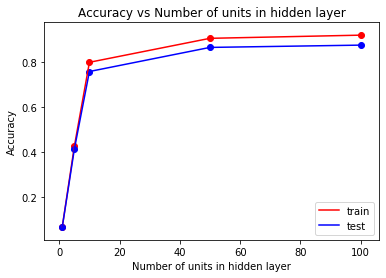

In [11]:
# Plotting the accuracies
def plot_accuracies(acc_train, acc_test, hidden_layer):
    plt.plot(hidden_layer, acc_train, label = "train", color='red')
    plt.plot(hidden_layer, acc_test, label = "test", color='blue')
    plt.scatter(hidden_layer, acc_train, color = 'red')
    plt.scatter(hidden_layer, acc_test, color='blue')
    plt.xlabel("Number of units in hidden layer")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of units in hidden layer")
    plt.legend()
    plt.show()
plot_accuracies(acc_train, acc_test, hidden_layer)

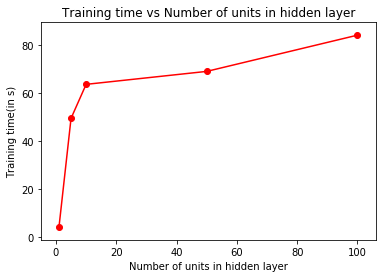

In [12]:
# Plotting training time
def plot_training_time(training_time, hidden_layer):
    plt.plot(hidden_layer, training_time, color='red')
    plt.scatter(hidden_layer, training_time, color='red')
    plt.xlabel("Number of units in hidden layer")
    plt.ylabel("Training time(in s)")
    plt.title("Training time vs Number of units in hidden layer")
    plt.show()
plot_training_time(training_time, hidden_layer)

In [13]:
print(acc_train)
print(acc_test)
print(training_time)

[0.06815384615384615, 0.42515384615384616, 0.7987692307692308, 0.9053076923076923, 0.9193846153846154]
[0.06723076923076923, 0.4127692307692308, 0.7578461538461538, 0.8649230769230769, 0.8750769230769231]
[4.31079888343811, 49.504825830459595, 63.63740587234497, 69.02524209022522, 84.09500408172607]


### Part C

In [14]:
acc_train_b, acc_test_b, training_time_b = get_accuracies(hidden_layer=hidden_layer,
                                                          EPSILON=1e-4,
                                                          learning_rate_type='adaptive',
                                                          learning_rate=0.5)

Training model:  1
#Epoch => 0 | Cost: 0 | Difference in cost => inf
#Epoch => 1 | Cost: 0.5102673408185242 | Difference in cost => -0.5102673408185242
#Epoch => 2 | Cost: 0.4924836008951325 | Difference in cost => 0.017783739923391717
#Epoch => 3 | Cost: 0.48751364457155566 | Difference in cost => 0.00496995632357683
#Epoch => 4 | Cost: 0.48527624142056613 | Difference in cost => 0.0022374031509895254
#Epoch => 5 | Cost: 0.48403615229150526 | Difference in cost => 0.0012400891290608729
#Epoch => 6 | Cost: 0.48326240437640317 | Difference in cost => 0.0007737479151020965
#Epoch => 7 | Cost: 0.4827410489669468 | Difference in cost => 0.0005213554094563588
#Epoch => 8 | Cost: 0.48237024516209537 | Difference in cost => 0.0003708038048514384
#Epoch => 9 | Cost: 0.4820957174663495 | Difference in cost => 0.0002745276957458742
#Epoch => 10 | Cost: 0.4818860665687568 | Difference in cost => 0.00020965089759267252
#Epoch => 11 | Cost: 0.48172195682132973 | Difference in cost => 0.000164109747

#Epoch => 74 | Cost: 0.46908579615958806 | Difference in cost => 8.269968770541203e-05
#Epoch => 75 | Cost: 0.4690051293947343 | Difference in cost => 8.066676485374291e-05
#Epoch => 76 | Cost: 0.468926388348142 | Difference in cost => 7.874104659233438e-05
Training complete | Epochs => 77 | Training accuracy => 0.07769230769230769
Training model:  10
#Epoch => 0 | Cost: 0 | Difference in cost => inf
#Epoch => 1 | Cost: 0.4821861051297885 | Difference in cost => -0.4821861051297885
#Epoch => 2 | Cost: 0.4802924905123909 | Difference in cost => 0.0018936146173975654
#Epoch => 3 | Cost: 0.47954778187179176 | Difference in cost => 0.0007447086405991676
#Epoch => 4 | Cost: 0.47891396551258836 | Difference in cost => 0.0006338163592033985
#Epoch => 5 | Cost: 0.4783060374453982 | Difference in cost => 0.0006079280671901777
#Epoch => 6 | Cost: 0.47771186163067025 | Difference in cost => 0.0005941758147279264
#Epoch => 7 | Cost: 0.4771312691434887 | Difference in cost => 0.0005805924871815638


#Epoch => 94 | Cost: 0.425679191620335 | Difference in cost => 0.0006379773723532711
#Epoch => 95 | Cost: 0.4250432136306648 | Difference in cost => 0.0006359779896702444
#Epoch => 96 | Cost: 0.42440906108545823 | Difference in cost => 0.0006341525452065455
#Epoch => 97 | Cost: 0.4237765747455779 | Difference in cost => 0.0006324863398803338
#Epoch => 98 | Cost: 0.4231456081732657 | Difference in cost => 0.0006309665723122082
#Epoch => 99 | Cost: 0.4225160257486781 | Difference in cost => 0.0006295824245876047
#Epoch => 100 | Cost: 0.42188770065811926 | Difference in cost => 0.0006283250905588234
#Epoch => 101 | Cost: 0.4212605129530964 | Difference in cost => 0.0006271877050228469
#Epoch => 102 | Cost: 0.42063434781262116 | Difference in cost => 0.0006261651404752544
#Epoch => 103 | Cost: 0.42000909416370996 | Difference in cost => 0.0006252536489111948
#Epoch => 104 | Cost: 0.419384643826286 | Difference in cost => 0.0006244503374239763
#Epoch => 105 | Cost: 0.4187608913492196 | Diff

#Epoch => 190 | Cost: 0.3723459074984077 | Difference in cost => 0.0004701567757821601
#Epoch => 191 | Cost: 0.37187779220188505 | Difference in cost => 0.00046811529652263095
#Epoch => 192 | Cost: 0.3714118296851009 | Difference in cost => 0.00046596251678415745
#Epoch => 193 | Cost: 0.37094812932403504 | Difference in cost => 0.0004637003610658552
#Epoch => 194 | Cost: 0.37048679850713806 | Difference in cost => 0.0004613308168969765
#Epoch => 195 | Cost: 0.3700279418692451 | Difference in cost => 0.00045885663789296816
#Epoch => 196 | Cost: 0.3695716599390174 | Difference in cost => 0.0004562819302276755
#Epoch => 197 | Cost: 0.3691180474413648 | Difference in cost => 0.00045361249765263345
#Epoch => 198 | Cost: 0.3686671915405203 | Difference in cost => 0.00045085590084448235
#Epoch => 199 | Cost: 0.3682191702837096 | Difference in cost => 0.0004480212568107045
#Epoch => 200 | Cost: 0.3677740514334728 | Difference in cost => 0.000445118850236792
#Epoch => 201 | Cost: 0.367331891786

#Epoch => 286 | Cost: 0.33825831667961875 | Difference in cost => 0.00028112089604909185
#Epoch => 287 | Cost: 0.33797797835107113 | Difference in cost => 0.00028033832854762464
#Epoch => 288 | Cost: 0.33769840705096293 | Difference in cost => 0.00027957130010819453
#Epoch => 289 | Cost: 0.3374195874334297 | Difference in cost => 0.0002788196175332325
#Epoch => 290 | Cost: 0.33714150434476475 | Difference in cost => 0.0002780830886649488
#Epoch => 291 | Cost: 0.33686414282319826 | Difference in cost => 0.0002773615215664882
#Epoch => 292 | Cost: 0.33658748809946654 | Difference in cost => 0.0002766547237317285
#Epoch => 293 | Cost: 0.3363115255981323 | Difference in cost => 0.00027596250133421485
#Epoch => 294 | Cost: 0.3360362409396223 | Difference in cost => 0.00027528465851001105
#Epoch => 295 | Cost: 0.33576161994294274 | Difference in cost => 0.0002746209966795754
#Epoch => 296 | Cost: 0.3354876486290357 | Difference in cost => 0.000273971313907051
#Epoch => 297 | Cost: 0.33521431

#Epoch => 382 | Cost: 0.3135534237837512 | Difference in cost => 0.0002372520742935369
#Epoch => 383 | Cost: 0.31331669390451444 | Difference in cost => 0.00023672987923673006
#Epoch => 384 | Cost: 0.31308048988634746 | Difference in cost => 0.00023620401816698555
#Epoch => 385 | Cost: 0.31284481528471686 | Difference in cost => 0.00023567460163059772
#Epoch => 386 | Cost: 0.31260967354487035 | Difference in cost => 0.00023514173984651165
#Epoch => 387 | Cost: 0.3123750680023426 | Difference in cost => 0.0002346055425277438
#Epoch => 388 | Cost: 0.312141001883609 | Difference in cost => 0.00023406611873361127
#Epoch => 389 | Cost: 0.3119074783068619 | Difference in cost => 0.00023352357674710778
#Epoch => 390 | Cost: 0.31167450028288535 | Difference in cost => 0.00023297802397653777
#Epoch => 391 | Cost: 0.31144207071600677 | Difference in cost => 0.00023242956687857808
#Epoch => 392 | Cost: 0.31121019240510694 | Difference in cost => 0.00023187831089982458
#Epoch => 393 | Cost: 0.3109

#Epoch => 478 | Cost: 0.2934285472771882 | Difference in cost => 0.00018286213374169025
#Epoch => 479 | Cost: 0.29324620511882976 | Difference in cost => 0.00018234215835843948
#Epoch => 480 | Cost: 0.2930643809786413 | Difference in cost => 0.00018182414018846904
#Epoch => 481 | Cost: 0.2928830728923246 | Difference in cost => 0.00018130808631666717
#Epoch => 482 | Cost: 0.29270227888904626 | Difference in cost => 0.0001807940032783617
#Epoch => 483 | Cost: 0.2925219969919666 | Difference in cost => 0.00018028189707963715
#Epoch => 484 | Cost: 0.2923422252187551 | Difference in cost => 0.00017977177321154558
#Epoch => 485 | Cost: 0.29216296158208527 | Difference in cost => 0.00017926363666981304
#Epoch => 486 | Cost: 0.29198420409011655 | Difference in cost => 0.00017875749196871737
#Epoch => 487 | Cost: 0.29180595074695903 | Difference in cost => 0.0001782533431575195
#Epoch => 488 | Cost: 0.2916281995531219 | Difference in cost => 0.0001777511938371168
#Epoch => 489 | Cost: 0.291450

#Epoch => 574 | Cost: 0.27800463566590394 | Difference in cost => 0.00014178516833140975
#Epoch => 575 | Cost: 0.2778631921879727 | Difference in cost => 0.000141443477931269
#Epoch => 576 | Cost: 0.27772208886568645 | Difference in cost => 0.00014110332228622902
#Epoch => 577 | Cost: 0.27758132417273873 | Difference in cost => 0.00014076469294771465
#Epoch => 578 | Cost: 0.2774408965912758 | Difference in cost => 0.00014042758146293188
#Epoch => 579 | Cost: 0.27730080461190204 | Difference in cost => 0.00014009197937375761
#Epoch => 580 | Cost: 0.2771610467336822 | Difference in cost => 0.0001397578782198483
#Epoch => 581 | Cost: 0.2770216214641437 | Difference in cost => 0.00013942526953847345
#Epoch => 582 | Cost: 0.27688252731927715 | Difference in cost => 0.00013909414486656946
#Epoch => 583 | Cost: 0.2767437628235367 | Difference in cost => 0.00013876449574046212
#Epoch => 584 | Cost: 0.2766053265098383 | Difference in cost => 0.00013843631369836462
#Epoch => 585 | Cost: 0.276467

#Epoch => 667 | Cost: 0.2661317729485488 | Difference in cost => 0.00011550455257131054
#Epoch => 668 | Cost: 0.26601650194048504 | Difference in cost => 0.00011527100806374424
#Epoch => 669 | Cost: 0.26590146366002926 | Difference in cost => 0.00011503828045578146
#Epoch => 670 | Cost: 0.2657866572966631 | Difference in cost => 0.00011480636336613781
#Epoch => 671 | Cost: 0.2656720820462124 | Difference in cost => 0.00011457525045072137
#Epoch => 672 | Cost: 0.26555773711081104 | Difference in cost => 0.00011434493540135593
#Epoch => 673 | Cost: 0.2654436216988625 | Difference in cost => 0.00011411541194855657
#Epoch => 674 | Cost: 0.2653297350250041 | Difference in cost => 0.00011388667385836548
#Epoch => 675 | Cost: 0.2652160763100681 | Difference in cost => 0.00011365871493601576
#Epoch => 676 | Cost: 0.2651026447810451 | Difference in cost => 0.00011343152902298925
#Epoch => 677 | Cost: 0.264989439671045 | Difference in cost => 0.00011320511000012523
#Epoch => 678 | Cost: 0.264876

#Epoch => 9 | Cost: 0.40567980466613957 | Difference in cost => 0.008657961981293816
#Epoch => 10 | Cost: 0.39774433226238903 | Difference in cost => 0.007935472403750532
#Epoch => 11 | Cost: 0.3904723309477123 | Difference in cost => 0.007272001314676757
#Epoch => 12 | Cost: 0.3837662152813347 | Difference in cost => 0.006706115666377577
#Epoch => 13 | Cost: 0.3775261002723741 | Difference in cost => 0.0062401150089606006
#Epoch => 14 | Cost: 0.3716658460837751 | Difference in cost => 0.005860254188598979
#Epoch => 15 | Cost: 0.3661166563185841 | Difference in cost => 0.005549189765191032
#Epoch => 16 | Cost: 0.3608254048612068 | Difference in cost => 0.0052912514573772995
#Epoch => 17 | Cost: 0.3557517596268865 | Difference in cost => 0.005073645234320301
#Epoch => 18 | Cost: 0.3508655129253147 | Difference in cost => 0.004886246701571784
#Epoch => 19 | Cost: 0.3461443879714422 | Difference in cost => 0.004721124953872502
#Epoch => 20 | Cost: 0.34157226169924526 | Difference in cost 

#Epoch => 105 | Cost: 0.1938282848621075 | Difference in cost => 0.0006010877123554526
#Epoch => 106 | Cost: 0.1932364447185385 | Difference in cost => 0.0005918401435690002
#Epoch => 107 | Cost: 0.19265361495701364 | Difference in cost => 0.0005828297615248779
#Epoch => 108 | Cost: 0.19207956642202897 | Difference in cost => 0.0005740485349846614
#Epoch => 109 | Cost: 0.19151407768100998 | Difference in cost => 0.000565488741018999
#Epoch => 110 | Cost: 0.1909569347272059 | Difference in cost => 0.000557142953804074
#Epoch => 111 | Cost: 0.19040793069357625 | Difference in cost => 0.0005490040336296464
#Epoch => 112 | Cost: 0.18986686557743507 | Difference in cost => 0.0005410651161411872
#Epoch => 113 | Cost: 0.18933354597559923 | Difference in cost => 0.0005333196018358355
#Epoch => 114 | Cost: 0.18880778482976948 | Difference in cost => 0.0005257611458297506
#Epoch => 115 | Cost: 0.1882894011818622 | Difference in cost => 0.0005183836479072945
#Epoch => 116 | Cost: 0.18777821993900

#Epoch => 198 | Cost: 0.1606178292815495 | Difference in cost => 0.00022289732347119395
#Epoch => 199 | Cost: 0.16039660279539494 | Difference in cost => 0.0002212264861545521
#Epoch => 200 | Cost: 0.1601770252143309 | Difference in cost => 0.00021957758106405656
#Epoch => 201 | Cost: 0.15995907501051812 | Difference in cost => 0.00021795020381276675
#Epoch => 202 | Cost: 0.15974273105096307 | Difference in cost => 0.00021634395955505425
#Epoch => 203 | Cost: 0.1595279725882506 | Difference in cost => 0.00021475846271246102
#Epoch => 204 | Cost: 0.15931477925154258 | Difference in cost => 0.00021319333670802298
#Epoch => 205 | Cost: 0.1591031310378314 | Difference in cost => 0.0002116482137111686
#Epoch => 206 | Cost: 0.15889300830344208 | Difference in cost => 0.00021012273438933415
#Epoch => 207 | Cost: 0.1586843917557724 | Difference in cost => 0.00020861654766968218
#Epoch => 208 | Cost: 0.15847726244526483 | Difference in cost => 0.00020712931050756445
#Epoch => 209 | Cost: 0.1582

#Epoch => 292 | Cost: 0.14499100751775018 | Difference in cost => 0.00012661180003764594
#Epoch => 293 | Cost: 0.14486500840002484 | Difference in cost => 0.000125999117725345
#Epoch => 294 | Cost: 0.14473961666362875 | Difference in cost => 0.00012539173639608547
#Epoch => 295 | Cost: 0.14461482707266426 | Difference in cost => 0.00012478959096448583
#Epoch => 296 | Cost: 0.14449063445528826 | Difference in cost => 0.00012419261737600662
#Epoch => 297 | Cost: 0.1443670337027019 | Difference in cost => 0.00012360075258635583
#Epoch => 298 | Cost: 0.14424401976815965 | Difference in cost => 0.0001230139345422543
#Epoch => 299 | Cost: 0.14412158766599692 | Difference in cost => 0.00012243210216272837
#Epoch => 300 | Cost: 0.14399973247067663 | Difference in cost => 0.00012185519532029176
#Epoch => 301 | Cost: 0.14387844931585408 | Difference in cost => 0.00012128315482254348
#Epoch => 302 | Cost: 0.14375773339345904 | Difference in cost => 0.0001207159223950427
#Epoch => 303 | Cost: 0.14

#Epoch => 31 | Cost: 0.24420612020018037 | Difference in cost => 0.0027409728833694413
#Epoch => 32 | Cost: 0.24160109273047217 | Difference in cost => 0.0026050274697081988
#Epoch => 33 | Cost: 0.23912227379518367 | Difference in cost => 0.002478818935288507
#Epoch => 34 | Cost: 0.23676068327193467 | Difference in cost => 0.0023615905232489964
#Epoch => 35 | Cost: 0.23450805372429753 | Difference in cost => 0.002252629547637136
#Epoch => 36 | Cost: 0.23235678337781382 | Difference in cost => 0.0021512703464837135
#Epoch => 37 | Cost: 0.23029988816478816 | Difference in cost => 0.0020568952130256557
#Epoch => 38 | Cost: 0.2283309543228195 | Difference in cost => 0.0019689338419686675
#Epoch => 39 | Cost: 0.22644409257222772 | Difference in cost => 0.0018868617505917729
#Epoch => 40 | Cost: 0.22463389453494248 | Difference in cost => 0.0018101980372852433
#Epoch => 41 | Cost: 0.22289539178528572 | Difference in cost => 0.0017385027496567562
#Epoch => 42 | Cost: 0.22122401772576356 | Dif

#Epoch => 127 | Cost: 0.16360455368550017 | Difference in cost => 0.00031982277092856837
#Epoch => 128 | Cost: 0.16328813137918685 | Difference in cost => 0.0003164223063133187
#Epoch => 129 | Cost: 0.1629750436826415 | Difference in cost => 0.00031308769654533886
#Epoch => 130 | Cost: 0.1626652265618611 | Difference in cost => 0.00030981712078040347
#Epoch => 131 | Cost: 0.1623586177388881 | Difference in cost => 0.00030660882297300907
#Epoch => 132 | Cost: 0.16205515662981973 | Difference in cost => 0.0003034611090683703
#Epoch => 133 | Cost: 0.16175478428548337 | Difference in cost => 0.0003003723443363582
#Epoch => 134 | Cost: 0.1614574433346414 | Difference in cost => 0.00029734095084196777
#Epoch => 135 | Cost: 0.16116307792960008 | Difference in cost => 0.0002943654050413247
#Epoch => 136 | Cost: 0.16087163369410096 | Difference in cost => 0.000291444235499122
#Epoch => 137 | Cost: 0.1605830576733823 | Difference in cost => 0.0002885760207186616
#Epoch => 138 | Cost: 0.160297298

#Epoch => 221 | Cost: 0.14313049825809684 | Difference in cost => 0.00015427210810525782
#Epoch => 222 | Cost: 0.14297711093764237 | Difference in cost => 0.00015338732045447334
#Epoch => 223 | Cost: 0.14282459898484284 | Difference in cost => 0.00015251195279952778
#Epoch => 224 | Cost: 0.14267295312486802 | Difference in cost => 0.00015164585997481939
#Epoch => 225 | Cost: 0.14252216422513156 | Difference in cost => 0.0001507888997364648
#Epoch => 226 | Cost: 0.14237222329244267 | Difference in cost => 0.00014994093268888564
#Epoch => 227 | Cost: 0.1422231214702268 | Difference in cost => 0.00014910182221586354
#Epoch => 228 | Cost: 0.14207485003581494 | Difference in cost => 0.00014827143441187296
#Epoch => 229 | Cost: 0.14192740039779952 | Difference in cost => 0.00014744963801541222
#Epoch => 230 | Cost: 0.14178076409345378 | Difference in cost => 0.0001466363043457486
#Epoch => 231 | Cost: 0.14163493278621378 | Difference in cost => 0.00014583130723999638
#Epoch => 232 | Cost: 0.

#Epoch => 315 | Cost: 0.13161429032477642 | Difference in cost => 9.896607006465441e-05
#Epoch => 316 | Cost: 0.1315157099237718 | Difference in cost => 9.858040100463317e-05
#Epoch => 317 | Cost: 0.13141751236789392 | Difference in cost => 9.819755587786583e-05
#Epoch => 318 | Cost: 0.13131969486314388 | Difference in cost => 9.781750475004736e-05
#Epoch => 319 | Cost: 0.13122225464504167 | Difference in cost => 9.744021810220715e-05
#Epoch => 320 | Cost: 0.13112518897821843 | Difference in cost => 9.70656668232428e-05
#Epoch => 321 | Cost: 0.13102849515601495 | Difference in cost => 9.669382220348077e-05
Training complete | Epochs => 322 | Training accuracy => 0.8659230769230769


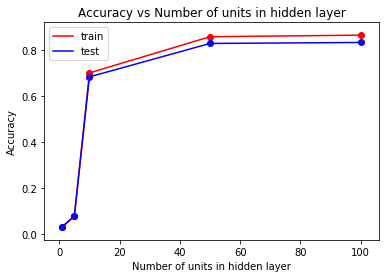

In [15]:
plot_accuracies(acc_train_b, acc_test_b, hidden_layer)

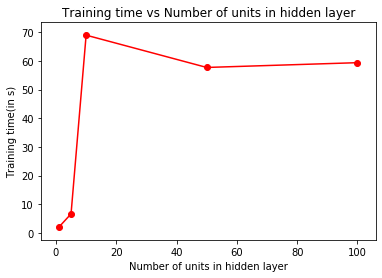

In [16]:
plot_training_time(training_time_b, hidden_layer)

In [17]:
print(acc_train_b)
print(acc_test_b)
print(training_time_b)

[0.031230769230769232, 0.07769230769230769, 0.7016153846153846, 0.8590769230769231, 0.8659230769230769]
[0.03307692307692308, 0.07923076923076923, 0.6843076923076923, 0.8298461538461539, 0.8341538461538461]
[2.018754005432129, 6.601818799972534, 68.99951195716858, 57.723564863204956, 59.39042115211487]


### Part D

In [18]:
# Sigmoid
model_sig = NeuralNetwork(batch_size=100, 
                              num_features=x_train.shape[-1], 
                              hidden_layers = [100, 100], 
                              target_classes= 26, 
                              learning_rate=0.5,
                              random=True,
                              learning_rate_type='adaptive',
                              EPSILON=1e-4)

In [19]:
%%time
model_sig.train(x_train_new, y_train_new)

#Epoch => 0 | Cost: 0 | Difference in cost => inf
#Epoch => 1 | Cost: 0.48022218564386193 | Difference in cost => -0.48022218564386193
#Epoch => 2 | Cost: 0.479798059212734 | Difference in cost => 0.0004241264311279358
#Epoch => 3 | Cost: 0.479436054352276 | Difference in cost => 0.0003620048604580095
#Epoch => 4 | Cost: 0.479104088293439 | Difference in cost => 0.0003319660588370077
#Epoch => 5 | Cost: 0.4787884919684178 | Difference in cost => 0.0003155963250212057
#Epoch => 6 | Cost: 0.4784817202304952 | Difference in cost => 0.0003067717379225954
#Epoch => 7 | Cost: 0.4781789346034922 | Difference in cost => 0.0003027856270029772
#Epoch => 8 | Cost: 0.4778766814661416 | Difference in cost => 0.00030225313735060544
#Epoch => 9 | Cost: 0.4775722797871789 | Difference in cost => 0.00030440167896267356
#Epoch => 10 | Cost: 0.477263498773972 | Difference in cost => 0.00030878101320691576
#Epoch => 11 | Cost: 0.47694837043205496 | Difference in cost => 0.0003151283419170481
#Epoch => 12 

#Epoch => 96 | Cost: 0.3594958740674714 | Difference in cost => 0.0015598320078055172
#Epoch => 97 | Cost: 0.3579399181692523 | Difference in cost => 0.001555955898219108
#Epoch => 98 | Cost: 0.3563879910945481 | Difference in cost => 0.0015519270747041958
#Epoch => 99 | Cost: 0.35484024889336274 | Difference in cost => 0.0015477422011853648
#Epoch => 100 | Cost: 0.3532968499569949 | Difference in cost => 0.0015433989363678458
#Epoch => 101 | Cost: 0.35175795436135465 | Difference in cost => 0.001538895595640244
#Epoch => 102 | Cost: 0.3502237234502776 | Difference in cost => 0.0015342309110770724
#Epoch => 103 | Cost: 0.3486943195648296 | Difference in cost => 0.0015294038854479775
#Epoch => 104 | Cost: 0.34716990583170754 | Difference in cost => 0.0015244137331220653
#Epoch => 105 | Cost: 0.3456506459340072 | Difference in cost => 0.0015192598977003535
#Epoch => 106 | Cost: 0.34413670380068057 | Difference in cost => 0.0015139421333266179
#Epoch => 107 | Cost: 0.34262824316659307 | D

#Epoch => 191 | Cost: 0.24307144576808684 | Difference in cost => 0.0008361514760152344
#Epoch => 192 | Cost: 0.24224330736213684 | Difference in cost => 0.0008281384059500019
#Epoch => 193 | Cost: 0.24142312781741612 | Difference in cost => 0.0008201795447207172
#Epoch => 194 | Cost: 0.2406108520859204 | Difference in cost => 0.0008122757314957263
#Epoch => 195 | Cost: 0.23980642431581256 | Difference in cost => 0.0008044277701078351
#Epoch => 196 | Cost: 0.23900978788571997 | Difference in cost => 0.0007966364300925899
#Epoch => 197 | Cost: 0.23822088543816566 | Difference in cost => 0.0007889024475543072
#Epoch => 198 | Cost: 0.23743965891227695 | Difference in cost => 0.0007812265258887174
#Epoch => 199 | Cost: 0.23666604957589474 | Difference in cost => 0.0007736093363822083
#Epoch => 200 | Cost: 0.2358999980571816 | Difference in cost => 0.0007660515187131456
#Epoch => 201 | Cost: 0.23514144437581244 | Difference in cost => 0.0007585536813691507
#Epoch => 202 | Cost: 0.2343903279

#Epoch => 285 | Cost: 0.19175674659179087 | Difference in cost => 0.0003473563361509613
#Epoch => 286 | Cost: 0.19141211504857228 | Difference in cost => 0.00034463154321859313
#Epoch => 287 | Cost: 0.19107017290212958 | Difference in cost => 0.00034194214644270304
#Epoch => 288 | Cost: 0.19073088529889504 | Difference in cost => 0.0003392876032345393
#Epoch => 289 | Cost: 0.19039421792161865 | Difference in cost => 0.0003366673772763895
#Epoch => 290 | Cost: 0.19006013698298568 | Difference in cost => 0.0003340809386329635
#Epoch => 291 | Cost: 0.18972860921913431 | Difference in cost => 0.00033152776385136917
#Epoch => 292 | Cost: 0.18939960188308505 | Difference in cost => 0.000329007336049264
#Epoch => 293 | Cost: 0.1890730827380977 | Difference in cost => 0.0003265191449873528
#Epoch => 294 | Cost: 0.18874902005096242 | Difference in cost => 0.0003240626871352792
#Epoch => 295 | Cost: 0.18842738258524028 | Difference in cost => 0.000321637465722141
#Epoch => 296 | Cost: 0.18810813

#Epoch => 378 | Cost: 0.16792003240984332 | Difference in cost => 0.0001933374885992878
#Epoch => 379 | Cost: 0.16772766448610307 | Difference in cost => 0.0001923679237402498
#Epoch => 380 | Cost: 0.1675362573036234 | Difference in cost => 0.0001914071824796748
#Epoch => 381 | Cost: 0.1673458021529722 | Difference in cost => 0.000190455150651192
#Epoch => 382 | Cost: 0.1671562904370123 | Difference in cost => 0.0001895117159599058
#Epoch => 383 | Cost: 0.1669677136690662 | Difference in cost => 0.00018857676794609146
#Epoch => 384 | Cost: 0.16678006347111632 | Difference in cost => 0.00018765019794989013
#Epoch => 385 | Cost: 0.16659333157203973 | Difference in cost => 0.0001867318990765865
#Epoch => 386 | Cost: 0.16640750980587657 | Difference in cost => 0.00018582176616316337
#Epoch => 387 | Cost: 0.1662225901101318 | Difference in cost => 0.00018491969574477296
#Epoch => 388 | Cost: 0.1660385645241087 | Difference in cost => 0.0001840255860230955
#Epoch => 389 | Cost: 0.16585542518

#Epoch => 471 | Cost: 0.15326338752336244 | Difference in cost => 0.00013014368022143397
#Epoch => 472 | Cost: 0.15313371397627537 | Difference in cost => 0.0001296735470870669
#Epoch => 473 | Cost: 0.15300450745319186 | Difference in cost => 0.00012920652308351377
#Epoch => 474 | Cost: 0.15287576487489032 | Difference in cost => 0.0001287425783015328
#Epoch => 475 | Cost: 0.15274748319168713 | Difference in cost => 0.00012828168320319633
#Epoch => 476 | Cost: 0.15261965938307112 | Difference in cost => 0.00012782380861600662
#Epoch => 477 | Cost: 0.15249229045734364 | Difference in cost => 0.00012736892572748348
#Epoch => 478 | Cost: 0.15236537345126389 | Difference in cost => 0.00012691700607975198
#Epoch => 479 | Cost: 0.15223890542969956 | Difference in cost => 0.00012646802156432435
#Epoch => 480 | Cost: 0.1521128834852828 | Difference in cost => 0.00012602194441677095
#Epoch => 481 | Cost: 0.1519873047380711 | Difference in cost => 0.00012557874721169648
#Epoch => 482 | Cost: 0.1

In [20]:
pred_train = model_sig.predict(x_train_new)
pred_test = model_sig.predict(x_test_new)

# Accuracy over different data sets
train_acc = np.sum(pred_train == y_train_) / y_train_.shape[0]
test_acc = np.sum(pred_test == y_test) / y_test.shape[0]

print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training accuracy:  0.8456153846153847
Test accuracy:  0.821076923076923


In [37]:
model_rel = NeuralNetwork(batch_size=100, 
                              num_features=x_train.shape[-1], 
                              hidden_layers = [100, 100], 
                              target_classes= 26, 
                              learning_rate=0.5, 
                              random=True,
                              activation = 'relu',
                              learning_rate_type='adaptive',
                              EPSILON=1e-4)

In [38]:
%%time
model_rel.train(x_train_new, y_train_new)

#Epoch => 0 | Cost: 0 | Difference in cost => inf
#Epoch => 1 | Cost: 0.3979004740313791 | Difference in cost => -0.3979004740313791
#Epoch => 2 | Cost: 0.31972219364183696 | Difference in cost => 0.07817828038954217
#Epoch => 3 | Cost: 0.2673179010313169 | Difference in cost => 0.05240429261052004
#Epoch => 4 | Cost: 0.22867929859719072 | Difference in cost => 0.0386386024341262
#Epoch => 5 | Cost: 0.20776950040238756 | Difference in cost => 0.020909798194803153
#Epoch => 6 | Cost: 0.1903641173535487 | Difference in cost => 0.017405383048838874
#Epoch => 7 | Cost: 0.17595209550270316 | Difference in cost => 0.01441202185084553
#Epoch => 8 | Cost: 0.1665103269594598 | Difference in cost => 0.009441768543243356
#Epoch => 9 | Cost: 0.15996848022948293 | Difference in cost => 0.0065418467299768746
#Epoch => 10 | Cost: 0.1548471166681968 | Difference in cost => 0.005121363561286119
#Epoch => 11 | Cost: 0.15065139614649786 | Difference in cost => 0.004195720521698948
#Epoch => 12 | Cost: 0.

#Epoch => 96 | Cost: 0.07037251094410192 | Difference in cost => 0.0002631945261545865
#Epoch => 97 | Cost: 0.07011718239997182 | Difference in cost => 0.0002553285441301012
#Epoch => 98 | Cost: 0.06986222609795231 | Difference in cost => 0.00025495630201950725
#Epoch => 99 | Cost: 0.06961290619346225 | Difference in cost => 0.000249319904490064
#Epoch => 100 | Cost: 0.06936184253032913 | Difference in cost => 0.0002510636631331137
#Epoch => 101 | Cost: 0.0691219782050058 | Difference in cost => 0.00023986432532333013
#Epoch => 102 | Cost: 0.06888168194251416 | Difference in cost => 0.0002402962624916405
#Epoch => 103 | Cost: 0.06864522658418797 | Difference in cost => 0.00023645535832619857
#Epoch => 104 | Cost: 0.06841218745646924 | Difference in cost => 0.0002330391277187288
#Epoch => 105 | Cost: 0.06818315393362907 | Difference in cost => 0.00022903352284016354
#Epoch => 106 | Cost: 0.06795772513045938 | Difference in cost => 0.00022542880316969716
#Epoch => 107 | Cost: 0.067731008

#Epoch => 189 | Cost: 0.055578263294133026 | Difference in cost => 0.00010321679853812077
#Epoch => 190 | Cost: 0.05548046853367498 | Difference in cost => 9.779476045804897e-05
#Epoch => 191 | Cost: 0.055383175386136296 | Difference in cost => 9.729314753868096e-05
#Epoch => 192 | Cost: 0.055286024068278136 | Difference in cost => 9.715131785816011e-05
#Epoch => 193 | Cost: 0.05519242108493056 | Difference in cost => 9.360298334757516e-05
#Epoch => 194 | Cost: 0.055093144358337 | Difference in cost => 9.927672659355846e-05
#Epoch => 195 | Cost: 0.054998443104239764 | Difference in cost => 9.47012540972389e-05
#Epoch => 196 | Cost: 0.054903968894251524 | Difference in cost => 9.447420998823924e-05
#Epoch => 197 | Cost: 0.054808361515342616 | Difference in cost => 9.560737890890875e-05
#Epoch => 198 | Cost: 0.054715991610583596 | Difference in cost => 9.236990475901957e-05
Training complete | Epochs => 199 | Training accuracy => 0.9200769230769231
CPU times: user 3min 9s, sys: 10.3 s, t

In [39]:
pred_train = model_rel.predict(x_train_new)
pred_test = model_rel.predict(x_test_new)

# Accuracy over different data sets
train_acc = np.sum(pred_train == y_train_) / y_train_.shape[0]
test_acc = np.sum(pred_test == y_test) / y_test.shape[0]

print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training accuracy:  0.9200769230769231
Test accuracy:  0.8716923076923077


### Part E

In [24]:
from sklearn.neural_network import MLPClassifier

In [31]:
clf = MLPClassifier(solver='sgd', 
                    batch_size=100,
                    learning_rate= 'invscaling',
                    learning_rate_init=0.5,
                    hidden_layer_sizes=(100, 100),
                    activation='relu',
                    power_t=0.5,
                    verbose=True,
                    max_iter=5000,
                    momentum=0,
                    nesterovs_momentum=False,
                    alpha=0,
                    shuffle=False
                    )

In [32]:
%%time
clf.fit(x_train_new.T, y_train_new.T)

Iteration 1, loss = 3.24921780
Iteration 2, loss = 1.26374633
Iteration 3, loss = 1.13738325
Iteration 4, loss = 1.11561502
Iteration 5, loss = 1.10283310
Iteration 6, loss = 1.09337853
Iteration 7, loss = 1.08578551
Iteration 8, loss = 1.07937496
Iteration 9, loss = 1.07379897
Iteration 10, loss = 1.06884934
Iteration 11, loss = 1.06440916
Iteration 12, loss = 1.06039465
Iteration 13, loss = 1.05671176
Iteration 14, loss = 1.05331017
Iteration 15, loss = 1.05015318
Iteration 16, loss = 1.04718691
Iteration 17, loss = 1.04438785
Iteration 18, loss = 1.04173561
Iteration 19, loss = 1.03921365
Iteration 20, loss = 1.03682342
Iteration 21, loss = 1.03454620
Iteration 22, loss = 1.03236771
Iteration 23, loss = 1.03028309
Iteration 24, loss = 1.02828531
Iteration 25, loss = 1.02636257
Iteration 26, loss = 1.02451488
Iteration 27, loss = 1.02273254
Iteration 28, loss = 1.02100975
Iteration 29, loss = 1.01934027
Iteration 30, loss = 1.01772340
Iteration 31, loss = 1.01615811
Iteration 32, los

Iteration 253, loss = 0.89377091
Iteration 254, loss = 0.89348489
Iteration 255, loss = 0.89319979
Iteration 256, loss = 0.89291569
Iteration 257, loss = 0.89263264
Iteration 258, loss = 0.89235060
Iteration 259, loss = 0.89206938
Iteration 260, loss = 0.89178886
Iteration 261, loss = 0.89150935
Iteration 262, loss = 0.89123067
Iteration 263, loss = 0.89095278
Iteration 264, loss = 0.89067579
Iteration 265, loss = 0.89039953
Iteration 266, loss = 0.89012414
Iteration 267, loss = 0.88984970
Iteration 268, loss = 0.88957600
Iteration 269, loss = 0.88930311
Iteration 270, loss = 0.88903110
Iteration 271, loss = 0.88875990
Iteration 272, loss = 0.88848945
Iteration 273, loss = 0.88821980
Iteration 274, loss = 0.88795088
Iteration 275, loss = 0.88768279
Iteration 276, loss = 0.88741539
Iteration 277, loss = 0.88714854
Iteration 278, loss = 0.88688256
Iteration 279, loss = 0.88661721
Iteration 280, loss = 0.88635256
Iteration 281, loss = 0.88608839
Iteration 282, loss = 0.88582506
Iteration 

Iteration 503, loss = 0.83987165
Iteration 504, loss = 0.83970421
Iteration 505, loss = 0.83953721
Iteration 506, loss = 0.83937048
Iteration 507, loss = 0.83920394
Iteration 508, loss = 0.83903766
Iteration 509, loss = 0.83887164
Iteration 510, loss = 0.83870599
Iteration 511, loss = 0.83854060
Iteration 512, loss = 0.83837538
Iteration 513, loss = 0.83821032
Iteration 514, loss = 0.83804560
Iteration 515, loss = 0.83788116
Iteration 516, loss = 0.83771704
Iteration 517, loss = 0.83755317
Iteration 518, loss = 0.83738953
Iteration 519, loss = 0.83722637
Iteration 520, loss = 0.83706341
Iteration 521, loss = 0.83690070
Iteration 522, loss = 0.83673816
Iteration 523, loss = 0.83657576
Iteration 524, loss = 0.83641373
Iteration 525, loss = 0.83625196
Iteration 526, loss = 0.83609033
Iteration 527, loss = 0.83592904
Iteration 528, loss = 0.83576790
Iteration 529, loss = 0.83560705
Iteration 530, loss = 0.83544638
Iteration 531, loss = 0.83528604
Iteration 532, loss = 0.83512590
Iteration 

Iteration 753, loss = 0.80448234
Iteration 754, loss = 0.80436107
Iteration 755, loss = 0.80424003
Iteration 756, loss = 0.80411904
Iteration 757, loss = 0.80399814
Iteration 758, loss = 0.80387735
Iteration 759, loss = 0.80375665
Iteration 760, loss = 0.80363615
Iteration 761, loss = 0.80351580
Iteration 762, loss = 0.80339545
Iteration 763, loss = 0.80327530
Iteration 764, loss = 0.80315532
Iteration 765, loss = 0.80303549
Iteration 766, loss = 0.80291582
Iteration 767, loss = 0.80279611
Iteration 768, loss = 0.80267662
Iteration 769, loss = 0.80255727
Iteration 770, loss = 0.80243806
Iteration 771, loss = 0.80231905
Iteration 772, loss = 0.80220000
Iteration 773, loss = 0.80208127
Iteration 774, loss = 0.80196242
Iteration 775, loss = 0.80184386
Iteration 776, loss = 0.80172540
Iteration 777, loss = 0.80160708
Iteration 778, loss = 0.80148887
Iteration 779, loss = 0.80137072
Iteration 780, loss = 0.80125275
Iteration 781, loss = 0.80113491
Iteration 782, loss = 0.80101703
Iteration 

MLPClassifier(activation='relu', alpha=0, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=5000, momentum=0,
              n_iter_no_change=10, nesterovs_momentum=False, power_t=0.5,
              random_state=None, shuffle=False, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [33]:
pred_train = clf.predict(x_train_new.T)
pred_test = clf.predict(x_test_new.T)

# Converting to 
pred_train = np.argmax(pred_train, axis=1)
pred_test = np.argmax(pred_test, axis=1)

# Accuracy over different data sets
train_acc = np.sum(pred_train == y_train_) / y_train_.shape[0]
test_acc = np.sum(pred_test == y_test) / y_test.shape[0]

print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training accuracy:  0.809076923076923
Test accuracy:  0.7663076923076924
